created by Ignacio Oguiza - email: oguiza@gmail.com

# How to work with numpy arrays in fastai2: time series classification

## Requirements

I'd like to share with you how you can work with (very large) numpy arrays in **fastai2** through a time series classification example. In this case we'll use a multivariate time series dataset.

**High level requirements:**

- Be able to work with *numpy arrays with any number of dimensions* (for example, univariate or multivariate time series)
- Data may be *larger than RAM*, so it may be in memory or on disk.
- Use data on disk with similar *performance* to data in memory.
- Data is often *split*: 
    - X, y
    - X_train, X_valid, y_train, y_valid
- Add *test dataset*.
- Add an *unlabeled dataset* (for example for semi-supervised/ self-supervised learning).


These are pretty challanging requirements. Let's see if fastai2 can meet them with little configuration.

## Import libraries

In [1]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseries'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseries
    else: 
        path = !pwd
        if path != ['/content/timeseries']: 
            %cd timeseries
        !pwd

In [2]:
#from nbdev.showdoc import *
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [3]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [4]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

## Load data

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.

In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

This framework I'm using can deal with numpy arrays on disk (np.memmap). If you are not familiar with them, you may want to take a look at the 00_How_to_efficiently_work_with_very_large_numpy_arrays.ipynb I've also shared.

In [5]:
pprint.pprint(get_UCR_univariate_list())

['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'ElectricDevices',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

In [6]:
pprint.pprint(get_UCR_multivariate_list())

['ArticularyWordRecognition',
 'AtrialFibrillation',
 'BasicMotions',
 'CharacterTrajectories',
 'Cricket',
 'DuckDuckGeese',
 'EigenWorms',
 'Epilepsy',
 'ERing',
 'EthanolConcentration',
 'FaceDetection',
 'FingerMovements',
 'HandMovementDirection',
 'Handwriting',
 'Heartbeat',
 'InsectWingbeat',
 'JapaneseVowels',
 'Libras',
 'LSST',
 'MotorImagery',
 'NATOPS',
 'PEMS-SF',
 'PenDigits',
 'PhonemeSpectra',
 'RacketSports',
 'SelfRegulationSCP1',
 'SelfRegulationSCP2',
 'SpokenArabicDigits',
 'StandWalkJump',
 'UWaveGestureLibrary']


In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

This framework I'm using can deal with numpy arrays on disk (np.memmap). If you are not familiar with them, you may want to take a look at the 00_How_to_efficiently_work_with_very_large_numpy_arrays.ipynb I've also shared. To demonstrate that I'll use the get_UCR_data on_disk=True.

In [7]:
# dataset id
dsid = 'StarLightCurves'

In [8]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)

Dataset: StarLightCurves
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



The proposed solutions only take X and y, not X_train, y_train, X_valid, y_valid.

Since data is already split between train and test in the UCR dataset, we are going to merge them and create some indices to split them in the same sets.

As I also want to demonstrate how you can use numpy arrays on disk, I'll merge data and save it to simulate you have an array on disk (load with mmap_mode='r').

In [9]:
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X)
np.save(f'{folder}/{dsid}/y.npy', y)
del X, y
X = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r')
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X)))))
X.shape, y.shape

((9236, 1, 1024), (9236,))

In [10]:
splits

((#1000) [0,1,2,3,4,5,6,7,8,9...],
 (#8236) [1000,1001,1002,1003,1004,1005,1006,1007,1008,1009...])

As we have used a mmap_mode when loading data, the numpy array class is np.memmap (it means data is being read directly from memory), which is a subclass of np.ndarray.

In [11]:
X_train.__class__, isinstance(X_train, np.ndarray)

(numpy.memmap, True)

☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Variables (1 for univariate or several for multivariate)
3. Length (aka timesteps)


All UEA & UCR Time Series Classification data have already been split between train and valid. When you use your own data, you'll have to split it yourself. We'll see examples of this in future notebooks.

## Building block: TSTensor

Since fastai is based on Pytorch, you'll need to somehow transform the numpy arrays to tensors at some point (TSTensor in our case). There's a transform function called ToTSTensor that transforms an array into a tensor of type TSTensor (which has a show method).

In [43]:
class TSTensor(TensorBase):

    @classmethod
    def create(cls, o): return cls(To2DPlus(o)) # creates a TSTensor with at least 2 dims of type float

    @property
    def vars(self): return self.shape[-2]

    @property
    def len(self): return self.shape[-1]
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        if self.ndim >= 3:   return f'TSTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 2: return f'TSTensor(vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 1: return f'TSTensor(len:{self.shape[-1]})'
        else: return self

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold')
        plt.tight_layout()
        return ax

@Transform
def ToTSTensor(o:np.ndarray): 
    """ Transforms input to tensor of dtype torch.float32"""
    return TSTensor.create(o)

If you don't use time series, you may want to modify TSTensor and ToTSTensor to meet your needs. I've created a simple example you may want to use.

In [13]:
class NumpyTensor(TensorBase):

    @classmethod
    def create(cls, o): return cls(ToTensor(o))
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold')
        plt.tight_layout()
        return ax

@Transform
def ToNumpyTensor(o:np.ndarray): 
    """ np.ndarray to tensor of dtype torch.float32"""
    return NumpyTensor.create(o)

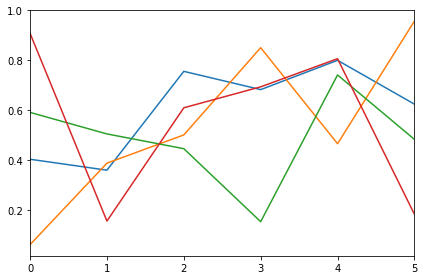

In [14]:
nt = ToNumpyTensor(np.random.rand(4, 6))
nt.show();

Let's go back to time series:

In [15]:
t = ToTSTensor(X_train[0])
t

TSTensor(vars:1, len:1024)

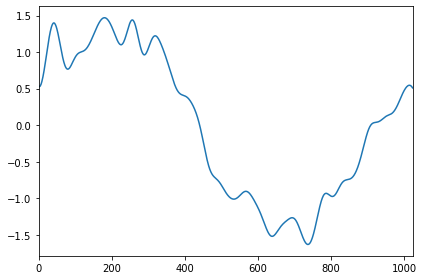

In [16]:
t.show();

In [17]:
t.vars, t.len, t.dtype

(1, 1024, torch.float32)

## Option 1: using the datablock API

To use the first option, we need this small custom code, to be able to create TSTensors from np.arrays.

In [18]:
def TSTensorBlock(): 
    return TransformBlock(item_tfms=ToTSTensor)

In [19]:
dblock = DataBlock(blocks=(TSTensorBlock(), CategoryBlock()),
                   get_x=ItemGetter(0), get_y=ItemGetter(1), 
                   splitter=IndexSplitter(splits[1]))
dls = dblock.dataloaders(source=itemify(X,y), bs=64, val_bs=128)

In [20]:
xb,yb = next(iter(dls.valid))
xb.shape, yb.shape

(torch.Size([128, 1, 1024]), torch.Size([128]))

In [21]:
# This is a convenience function proposed by Thomas Capelle @tcapelle to be able to easily benchmark performance
def cycle_dl(dl):
    for x,y in iter(dl): pass

In [22]:
%time cycle_dl(dls.valid)

CPU times: user 175 ms, sys: 145 ms, total: 321 ms
Wall time: 3.69 s


## Option 2: datasets + dataloaders

The second option requires to slightly modify Datasets and TfmdDL to take numpy arrays.

In [44]:
class NumpyDatasets(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
        super().__init__(dl_type=dl_type)

        #New 4 lines of code
        if tls is None:
            if items is None: items = itemify(X,) if y is None else itemify(X,y)
            assert (tfms is None or len(items[0]) == len(tfms)), f"n_tfms ({len(tfms)}) doesn't match n_items ({len(items[0])})"
            tfms = None if tfms is None else [[ItemGetter(i)] + L(tfms[i]) for i in range(len(items[0]))]
        
        self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

    def __getitem__(self, it):
        res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))

    def __getattr__(self,k): return gather_attrs(self, k, 'tls')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
    def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    def overlapping_splits(self): return self.tls[0].overlapping_splits()
    @property
    def splits(self): return self.tls[0].splits
    @property
    def split_idx(self): return self.tls[0].tfms.split_idx
    @property
    def items(self): return self.tls[0].items
    @items.setter
    def items(self, v):
        for tl in self.tls: tl.items = v

    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    def new_empty(self):
        tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
        return type(self)(tls=tls, n_inp=self.n_inp)

    @contextmanager
    def set_split_idx(self, i):
        old_split_idx = self.split_idx
        for tl in self.tls: tl.tfms.split_idx = i
        yield self
        for tl in self.tls: tl.tfms.split_idx = old_split_idx

Let's now build the datasets. We are going to use 2 transforms: 

- ToTSTensor: to transform X array into a TSTensor
- Categorize(): to create a tensor label based on a dictionary of unique classes

These are item transforms in fastai2 since we need to perform them at the item level, before a batch is created as the inputs to a batch must be tensors not numpy arrays.

In [45]:
tfms = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(X, y, tfms=tfms, splits=splits)

X data (that, remember, may be larger than RAM) is still on disk. Data conversion occurs only on demand (when you get an item from all items using __getitem__. When a batch needs to be created, the random selected samples are brought into memory and transformed into a tensor. This process occurs very quickly as I also showed in the 00 tutorial notebook. In this way you can efficiently use large numpy arrays with fastai2.

In [46]:
# A single item as stored in items (class np.memmap --> on disk)
dsets.items[0]

(memmap([[0.5373029 , 0.53110296, 0.52850294, ..., 0.52640295, 0.51950294,
          0.51140296]], dtype=float32), '3')

Here we select an item from the dataset, so the item is transformed into a TSTensor and a TensorCategory (a tuple is created)

In [47]:
# In memory
dsets[0]

(TSTensor(vars:1, len:1024), TensorCategory(2))

In [48]:
dsets[0][0], dsets[0][0].data

(TSTensor(vars:1, len:1024),
 tensor([[0.5373, 0.5311, 0.5285,  ..., 0.5264, 0.5195, 0.5114]]))

In [49]:
len(dsets.train), len(dsets.valid)

(1000, 8236)

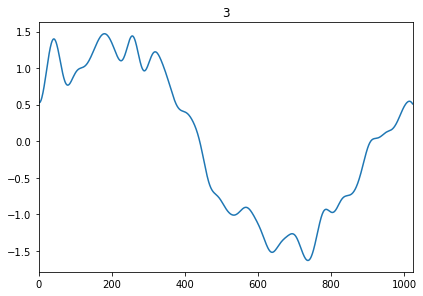

In [50]:
dsets.show(dsets.train[0]);

For convenience, I've also adapted the TfmdDL to work more easily with time series. But most of the functionality is still the original fastai2.

In [51]:
#export
class TSTfmdDL(TfmdDL): 

    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def len(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if nrows is None: 
            sqrt = math.sqrt(len(db))
            rows = min(math.ceil(sqrt), len(db)) 
        if ncols is None: ncols = len(db) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(db[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(tup, ax=ax)
        plt.tight_layout()

    def test_dl(self:DataLoaders, test_items, rm_type_tfms=None, with_labels=False, **kwargs):
        "Create a test dataloader from `test_items` using validation transforms of `dls`"
        test = test_set(self.valid, test_items, rm_tfms=rm_type_tfms, with_labels=with_labels
                        ) if isinstance(self.valid, (Datasets, NumpyDatasets, TfmdLists)) else test_items
        return self.valid.new(test, **kwargs)

@delegates(plt.subplots)
def show_tuple(tup, ax=None, **kwargs):
    "Display a timeseries plot from a tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], ax=ax, **kwargs)

In [52]:
dls = TSTfmdDL(dsets, bs=64, val_bs=128)

In [53]:
xb, yb = dls.one_batch()
xb, yb

(TSTensor(samples:64, vars:1, len:1024),
 TensorCategory([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0]))

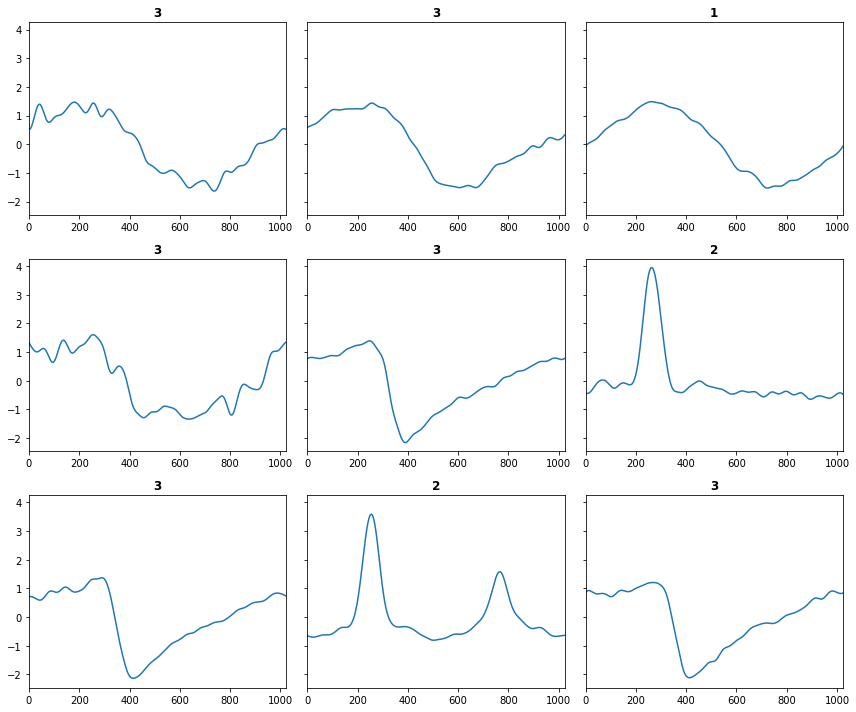

In [54]:
dls.show_batch(nrows=3, ncols=3, figsize=(12, 10), sharey=True)

So this is all the code you need to create dataloaders. We see that we can pass X and y either as np.arrays in memory or arrays on disk (np.memmap). NumpyDatasets accepts both types of arrays.

In [55]:
tfms  = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(np.array(X), np.array(y), tfms=tfms, splits=splits)
dls_in_memory   = TSTfmdDL(dsets, bs=64, val_bs=128)

In [56]:
tfms  = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(X, y, tfms=tfms, splits=splits)
dls_on_disk   = TSTfmdDL(dsets, bs=64, val_bs=128)

Let's compare performance between using data in memory vs data on disk: 

In [57]:
# Data in memory
%timeit cycle_dl(dls_in_memory.valid)

8.63 s ± 422 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
# Data on disk
%timeit cycle_dl(dls_on_disk.valid)

9.17 s ± 762 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So 2 learnings: 

- The 2nd option (build dataset + dataloader) seems to work a bit faster. I've run tests on different datasets, and the 2nd option has always come up a bit faster than the first one. It also provide some additional benefits (like the show_batch functionality, for example).

- It makes no difference whether we use data in memory or on disk. That's great, as it allows to use this solution even with larger than memory datasets!

## Train model

So here is all the code you need to train a model.

In [82]:
# tfms  = [[ToTSTensor], [Categorize()]]
# dsets = NumpyDatasets(X, y, tfms=tfms, splits=splits)
# dls   = TSTfmdDL(dsets, bs=64, val_bs=128)
# model = InceptionTime(dls.vars, dls.c)
# learn = Learner(dls.dataloaders(), model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
# learn.fit_one_cycle(25, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.125797,1.173800,0.142909,00:07
1,0.841928,0.778750,0.849441,00:07
2,0.677796,0.459597,0.848106,00:07
3,0.566405,0.520368,0.804638,00:07
4,0.482947,0.386302,0.882831,00:07
5,0.408022,0.703790,0.820423,00:07
6,0.347249,0.265960,0.859883,00:07
7,0.292497,0.316925,0.923992,00:07
8,0.254892,0.236005,0.902987,00:07
9,0.221642,0.322845,0.871661,00:07


## Add test set

One additional requirement is to be able to add a test set for inference. This can be done with a small modification of the test_set function to allow for NumpyDatasets:

In [38]:
def add_data(dsets, X=None, y=None, test_items=None, rm_tfms=None, with_labels=False):
    "Create a test or unlabeled sets from `items` using validation transforms of `dsets`"
    items = itemify(X,) if y is None else itemify(X, y)
    if y is None: with_labels = False
    else: with_labels = True
    if isinstance(dsets, (Datasets, NumpyDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = [tl._new(items, split_idx=1) for tl in tls]
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(items)) for tl in new_tls]
        else:               rm_tfms = tuplify(rm_tfms, match=new_tls)
        for i,j in enumerate(rm_tfms): new_tls[i].tfms.fs = new_tls[i].tfms.fs[j:]
        if isinstance(dsets, Datasets):return Datasets(tls=new_tls)
        else: return NumpyDatasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(items))
        new_tl.tfms.fs = new_tl.tfms.fs[rm_tfms:]
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

NumpyDatasets.add_data = add_data

To create the test dataloader, we'll pretend that X and y are test data since the UCR dataset only provides 2 sets of data we've used as train and valid.

In [39]:
tfms    = [[ToTSTensor], [Categorize()]]
dsets   = NumpyDatasets(X, y, tfms=tfms, splits=splits)
tst_set = dsets.add_data(X)
tst_dl  = TSTfmdDL(tst_set, bs=128)
b       = tst_dl.one_batch()
b

(TSTensor(samples:128, vars:1, len:1024),)

The transforms applied to the test set are the same applied to the valid set.

In [40]:
tst_set.tls[0].tfms

Pipeline: itemgetter -> ToTSTensor

We can even create a test set with labeled examples in case we want to measure performance during inference:

In [41]:
tfms    = [[ToTSTensor], [Categorize()]]
dsets   = NumpyDatasets(X, y, tfms=tfms, splits=splits)
tst_set = dsets.add_data(X, y)
tst_dl  = TSTfmdDL(tst_set, bs=128)
b       = tst_dl.one_batch()
b

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
         1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1,
         2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
         2, 2, 2, 2, 1, 2, 0, 2]))

## Unlabeled datasets

Sometimes we need to create a dataloader that load just unlabeled data, processed in the same way as valid. This can be done in exactly the same way as the add test data. 

This is very common when using semi-supervised or self.supervised learning. 
I also wanted to check that this approach can handle those scenarios as well:

In [42]:
tfms  = [[ToTSTensor]]
dsets = NumpyDatasets(X, tfms=tfms, splits=splits)
uset  = dsets.add_data(X)
udl   = TSTfmdDL(uset, bs=128)
xb    = udl.one_batch()
xb

(TSTensor(samples:128, vars:1, len:1024),)

It returns tuples with just 1 element. Good. That's exactly what we need!

## Summary

Well, we've seen how we can meet all the requirements we listed before:

- Be able to work with *numpy arrays with any number of dimensions* (for example, univariate or multivariate time series). ✅
- Data may be *larger than RAM*, so it may be in memory or on disk. ✅
- Use data on disk with similar *performance* to data in memory. ✅
- Data is often *split*: 
    - X, y ✅
    - X_train, X_valid, y_train, y_valid ✅
- Add *test dataset*. ✅
- Add an *unlabeled dataset* (for example for semi-supervised/ self-supervised learning). ✅

All of them, together, is a pretty challanging set of requirements.

I must say I'm impressed how little coding is necessary in fastai2 to meet all these numpy arrays/ time series requirements.

I hope this provides some help on ways to leverage this excellent library!